In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)


In [5]:
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [7]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3
)


In [8]:
epochs = 20

train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}]  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")


Epoch [1/20]  Train Acc: 0.7985  Val Acc: 0.8761
Epoch [2/20]  Train Acc: 0.8650  Val Acc: 0.8937
Epoch [3/20]  Train Acc: 0.8847  Val Acc: 0.9039
Epoch [4/20]  Train Acc: 0.8941  Val Acc: 0.9047
Epoch [5/20]  Train Acc: 0.8975  Val Acc: 0.9036
Epoch [6/20]  Train Acc: 0.9031  Val Acc: 0.9061
Epoch [7/20]  Train Acc: 0.9078  Val Acc: 0.9138
Epoch [8/20]  Train Acc: 0.9102  Val Acc: 0.9157
Epoch [9/20]  Train Acc: 0.9148  Val Acc: 0.9178
Epoch [10/20]  Train Acc: 0.9149  Val Acc: 0.9183
Epoch [11/20]  Train Acc: 0.9175  Val Acc: 0.9190
Epoch [12/20]  Train Acc: 0.9202  Val Acc: 0.9221
Epoch [13/20]  Train Acc: 0.9221  Val Acc: 0.9221
Epoch [14/20]  Train Acc: 0.9234  Val Acc: 0.9260
Epoch [15/20]  Train Acc: 0.9254  Val Acc: 0.9248
Epoch [16/20]  Train Acc: 0.9256  Val Acc: 0.9237
Epoch [17/20]  Train Acc: 0.9277  Val Acc: 0.9270
Epoch [18/20]  Train Acc: 0.9307  Val Acc: 0.9256
Epoch [19/20]  Train Acc: 0.9300  Val Acc: 0.9252
Epoch [20/20]  Train Acc: 0.9320  Val Acc: 0.9287


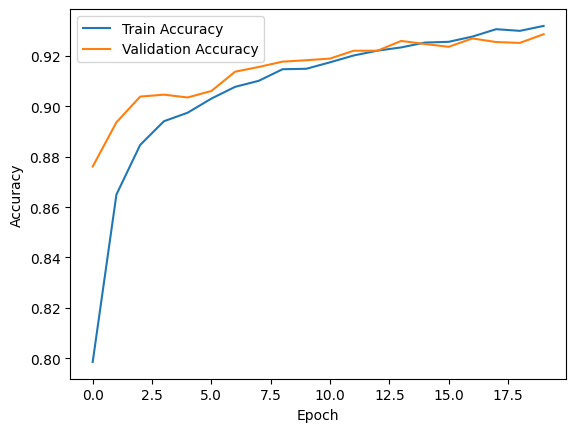

In [9]:
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [10]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())


In [11]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.88      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.86      0.92      0.89      1000
       Dress       0.91      0.94      0.92      1000
        Coat       0.88      0.88      0.88      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.81      0.74      0.77      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



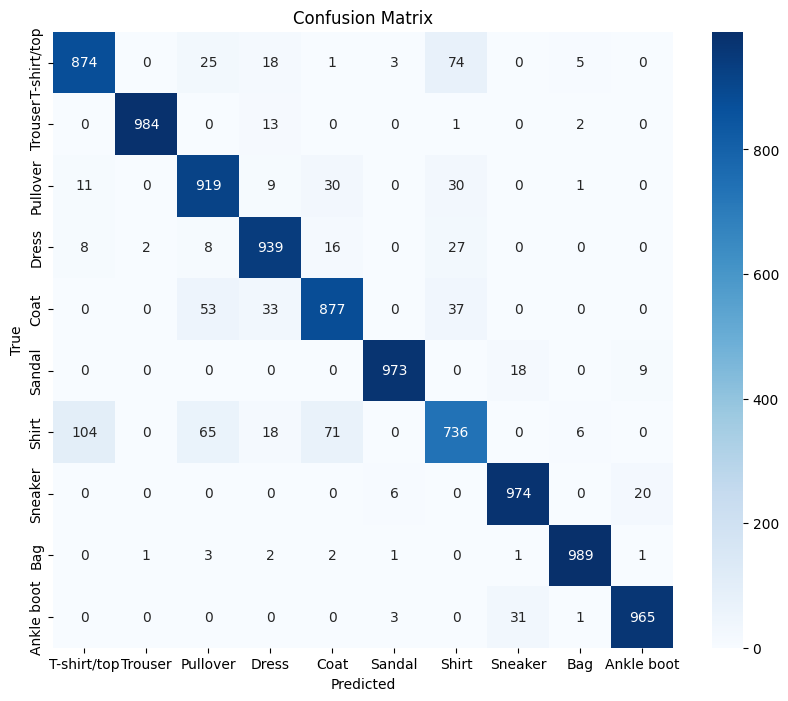

In [12]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
